In [1]:
!pip install pyod
!pip install prince
!pip install yellowbrick
!pip install lightgbm
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=f9d4d47696ab256f1440646686c846c0bf5da87327da5ea6cfab2e37a3afc6f2
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.8/415.8 kB 5.1 MB/s eta 0:00:00


In [2]:
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity

# sentence transformer
from sentence_transformers import SentenceTransformer

import networkx as nx

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Useful functions

In [3]:
def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter_3d(df,
                        x='comp1',
                        y='comp2',
                        z='comp3',
                        color='cluster',
                        template="plotly",

                        # symbol = "cluster",

                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000,
                                height = 800,
                                autosize = False,
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))


    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter(df,
                        x='comp1',
                        y='comp2',
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",

                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800,
                                height = 700,
                                autosize = False,
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))


    fig.show()

def random_sample(df: pd.DataFrame, num_rows: int) -> pd.DataFrame:
    """
    Returns a DataFrame with a specific number of rows randomly selected.

    Parameters:
    df (pd.DataFrame): Original DataFrame.
    num_rows (int): Number of rows to be randomly sampled.

    Returns:
    pd.DataFrame: New DataFrame with the random rows.
    """
    if num_rows > len(df):
        raise ValueError(f"The number of requested rows ({num_rows}) exceeds the number of rows in the DataFrame ({len(df)}).")

    return df.sample(n=num_rows, random_state=42)  # random_state is optional to ensure reproducibility

def compile_text(x):

    text =  f"""Age: {x['age']},
                housing load: {x['housing']},
                Job: {x['job']},
                Marital: {x['marital']},
                Education: {x['education']},
                Default: {x['default']},
                Balance: {x['balance']},
                Personal loan: {x['loan']}
            """

    return text

def calculate_cosine_similarity(embeddings: list) -> np.ndarray:
    """
    Calculates the cosine similarity between each pair of embeddings.

    Parameters:
    embeddings (list): A list of n-dimensional embeddings (each embedding is a list or a numpy array).

    Returns:
    np.ndarray: A matrix where each element [i, j] represents the cosine similarity between embedding i and j.
    """
    # Convert the list of embeddings to a NumPy array (if not already)
    embeddings_array = np.array(embeddings)

    # Compute the cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings_array)

    return similarity_matrix

def create_similarity_graph(similarity_matrix: np.ndarray, threshold: float) -> nx.Graph:
    """
    Creates an undirected graph from a similarity matrix where edges are formed
    between nodes with similarity greater than or equal to a given threshold.

    Parameters:
    similarity_matrix (np.ndarray): The matrix of cosine similarities.
    threshold (float): The minimum similarity value to create an edge.

    Returns:
    nx.Graph: An undirected graph where nodes are connected if their similarity is above the threshold.
    """
    # Create an empty undirected graph
    graph = nx.Graph()

    # Number of embeddings (nodes)
    num_nodes = similarity_matrix.shape[0]

    # Add nodes to the graph
    graph.add_nodes_from(range(num_nodes))

    # Add edges based on the similarity threshold
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if similarity_matrix[i, j] >= threshold:
                graph.add_edge(i, j, weight=similarity_matrix[i, j])

    return graph

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/EGC410043/'

Get Data

In [6]:
df = pd.read_csv(path+"train.csv", sep = ";")
df = df.iloc[:, 0:8]
df

,age,job,marital,education,default,balance,housing,loan
0,58,management,married,tertiary,no,2143,yes,no
1,44,technician,single,secondary,no,29,yes,no
2,33,entrepreneur,married,secondary,no,2,yes,yes
3,47,blue-collar,married,unknown,no,1506,yes,no
4,33,unknown,single,unknown,no,1,no,no
...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no
45207,71,retired,divorced,primary,no,1729,no,no
45208,72,retired,married,secondary,no,5715,no,no
45209,57,blue-collar,married,secondary,no,668,no,no


In [27]:
sample_rows = 500
df_sample = random_sample(df, sample_rows)
df_sample

,age,job,marital,education,default,balance,housing,loan
3776,40,blue-collar,married,secondary,no,580,yes,no
9928,47,services,single,secondary,no,3644,no,no
33409,25,student,single,tertiary,no,538,yes,no
31885,42,management,married,tertiary,no,1773,no,no
15738,56,management,married,tertiary,no,217,no,yes
...,...,...,...,...,...,...,...,...
24185,57,blue-collar,married,secondary,no,5270,yes,no
16084,26,student,single,secondary,no,141,no,no
18714,46,technician,married,secondary,no,499,yes,no
10406,56,blue-collar,married,secondary,no,2190,no,yes


In [28]:
sentences = df_sample.apply(lambda x: compile_text(x), axis=1).tolist()
sentences

['Age: 40,\n                housing load: yes,\n                Job: blue-collar,\n                Marital: married,\n                Education: secondary,\n                Default: no,\n                Balance: 580,\n                Personal loan: no\n            ',
 'Age: 47,\n                housing load: no,\n                Job: services,\n                Marital: single,\n                Education: secondary,\n                Default: no,\n                Balance: 3644,\n                Personal loan: no\n            ',
 'Age: 25,\n                housing load: yes,\n                Job: student,\n                Marital: single,\n                Education: tertiary,\n                Default: no,\n                Balance: 538,\n                Personal loan: no\n            ',
 'Age: 42,\n                housing load: no,\n                Job: management,\n                Marital: married,\n                Education: tertiary,\n                Default: no,\n                Balanc

In [29]:
#https://sbert.net/
# obtaining the embeddings from the sentences
model = SentenceTransformer("all-MiniLM-L6-v2")
output = model.encode(sentences=sentences,
         show_progress_bar=True,
         normalize_embeddings=True)

embeddings = pd.DataFrame(output)
print(embeddings)
#print(embeddings.shape)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

          0         1         2         3         4         5         6    \
0    0.014448 -0.052341 -0.012653  0.029094 -0.062213  0.016572 -0.049109   
1    0.032942 -0.040201 -0.025088  0.008775 -0.066076  0.019556 -0.057040   
2   -0.002160 -0.053828  0.003062  0.003901 -0.066806 -0.003891 -0.039474   
3    0.025024 -0.037959  0.002662  0.034724 -0.066949  0.033509 -0.056318   
4    0.038388 -0.062310 -0.025357  0.009138 -0.103340 -0.001652 -0.040332   
..        ...       ...       ...       ...       ...       ...       ...   
495  0.001631 -0.047172 -0.017164  0.028075 -0.067891  0.015021 -0.029167   
496  0.018190 -0.036785 -0.024504  0.012441 -0.063075  0.010354 -0.057223   
497  0.018673 -0.040696  0.001173  0.023216 -0.085669 -0.002719 -0.028054   
498  0.012396 -0.051959 -0.024299  0.018987 -0.082794  0.002064 -0.055456   
499  0.018327 -0.053759 -0.008700  0.008034 -0.076544  0.017581 -0.040167   

          7         8         9    ...       374       375       376  \
0  

In [30]:
# Calculates the cosine similarity between each pair of embeddings.
sim_matrix = calculate_cosine_similarity(embeddings)
print(sim_matrix)
print(sim_matrix.shape)

[[0.99999976 0.8931705  0.92752886 ... 0.91891277 0.9478919  0.92864597]
 [0.8931705  1.0000002  0.9209485  ... 0.9252324  0.94535613 0.9421183 ]
 [0.92752886 0.9209485  1.0000002  ... 0.9314291  0.92684233 0.9641793 ]
 ...
 [0.91891277 0.9252324  0.9314291  ... 1.0000001  0.93811184 0.9430318 ]
 [0.9478919  0.94535613 0.92684233 ... 0.93811184 0.9999999  0.943143  ]
 [0.92864597 0.9421183  0.9641793  ... 0.9430318  0.943143   1.0000001 ]]
(500, 500)


Best Number of Clusters

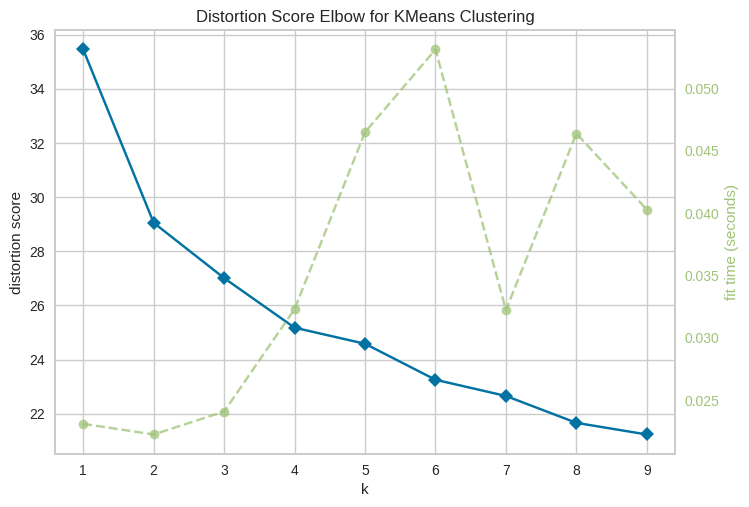

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
# Instantiate the clustering model and visualizer
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(1,10), locate_elbow=False)

visualizer.fit(embeddings)        # Fit the data to the visualizer
visualizer.show()

Clustering

In [32]:
n_clusters = 4

In [34]:
clusters = KMeans(n_clusters=n_clusters, init = "k-means++").fit(embeddings)
#print(clusters.inertia_)
clusters_predict = clusters.predict(embeddings)

In [35]:
pca_3d_object, df_pca_3d = get_pca_3d(embeddings, clusters_predict)
plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)
#print("The variability is :", pca_3d_object.eigenvalues_summary)

In [15]:
pca_2d_object, df_pca_2d = get_pca_2d(embeddings, clusters_predict)
plot_pca_2d(df_pca_2d, title = "PCA Space", opacity=1, width_line = 0.1)

In [16]:
graph = create_similarity_graph(sim_matrix, 0.95)
print(graph.edges(data=True))

[(0, 8, {'weight': 0.957868}), (0, 11, {'weight': 0.9619485}), (0, 23, {'weight': 0.9617057}), (0, 29, {'weight': 0.9558469}), (0, 40, {'weight': 0.9610728}), (0, 52, {'weight': 0.96233875}), (0, 54, {'weight': 0.9581919}), (0, 65, {'weight': 0.9541427}), (0, 74, {'weight': 0.9778948}), (1, 3, {'weight': 0.9521918}), (1, 7, {'weight': 0.96193373}), (1, 10, {'weight': 0.9615743}), (1, 19, {'weight': 0.96331036}), (1, 26, {'weight': 0.97161543}), (1, 27, {'weight': 0.9694679}), (1, 30, {'weight': 0.9608282}), (1, 32, {'weight': 0.9626863}), (1, 33, {'weight': 0.95912683}), (1, 42, {'weight': 0.95681095}), (1, 49, {'weight': 0.95249104}), (1, 53, {'weight': 0.95227265}), (1, 56, {'weight': 0.9533704}), (1, 59, {'weight': 0.9711992}), (1, 60, {'weight': 0.97154915}), (1, 64, {'weight': 0.9685771}), (1, 80, {'weight': 0.95051277}), (1, 85, {'weight': 0.95474577}), (1, 89, {'weight': 0.95041627}), (1, 91, {'weight': 0.9701109}), (1, 92, {'weight': 0.9532261}), (1, 99, {'weight': 0.95211077})

In [17]:
num_nodes = graph.number_of_nodes()
num_edges = graph.number_of_edges()
print(num_nodes)
print(num_edges)

100
913


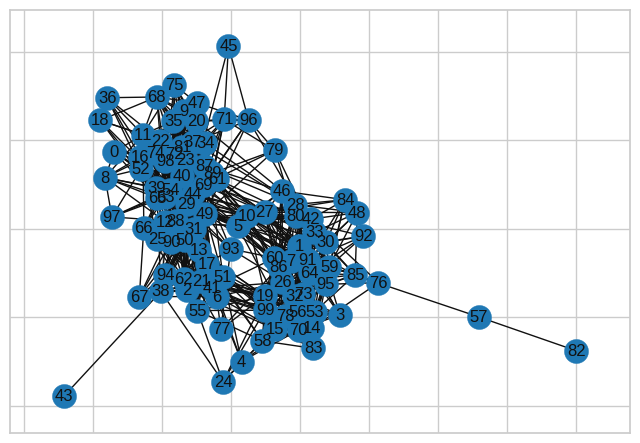

In [18]:
nx.draw_networkx(graph)

In [19]:
nx.write_graphml(graph, path+"network.graphml")

In [20]:
df_3d = df_pca_3d.iloc[:, 0:3]
df_3d

,comp1,comp2,comp3
0,-10.925414,7.780562,1.903128
1,9.270381,3.552714,-4.660319
2,-1.907095,-9.374292,4.326080
3,11.185278,-1.540198,-0.981045
4,3.173126,-8.348986,-4.543192
...,...,...,...
95,7.719254,2.032221,0.062914
96,-5.287403,-2.521590,-10.740925
97,-5.899411,2.093367,12.744549
98,-9.124724,-3.395024,-0.869363


In [21]:
# Calculates the cosine similarity between each pair of reduced embeddings.
sim_matrix_red = calculate_cosine_similarity(df_3d)
sim_matrix_red

array([[ 1.        , -0.55534428, -0.3084302 , ...,  0.54584614,
         0.5408788 , -0.94985166],
       [-0.55534428,  1.        , -0.6178684 , ..., -0.68484754,
        -0.86380139,  0.52207436],
       [-0.3084302 , -0.6178684 ,  1.        , ...,  0.31367441,
         0.44304381,  0.31987223],
       ...,
       [ 0.54584614, -0.68484754,  0.31367441, ...,  1.        ,
         0.25682142, -0.2963325 ],
       [ 0.5408788 , -0.86380139,  0.44304381, ...,  0.25682142,
         1.        , -0.66516569],
       [-0.94985166,  0.52207436,  0.31987223, ..., -0.2963325 ,
        -0.66516569,  1.        ]])

In [22]:
graph_red = create_similarity_graph(sim_matrix_red, 0.70)
print(graph_red.edges(data=True))

[(0, 8, {'weight': 0.817768098297465}), (0, 9, {'weight': 0.8885318512669402}), (0, 11, {'weight': 0.9527217329280196}), (0, 16, {'weight': 0.8360193818502397}), (0, 18, {'weight': 0.9286132452980904}), (0, 22, {'weight': 0.7262097517299514}), (0, 23, {'weight': 0.9885679558799452}), (0, 36, {'weight': 0.7853624826778527}), (0, 39, {'weight': 0.8258157974850657}), (0, 40, {'weight': 0.9750981024722203}), (0, 44, {'weight': 0.8818871430869846}), (0, 52, {'weight': 0.915583615860509}), (0, 54, {'weight': 0.8748207197332427}), (0, 63, {'weight': 0.8251244431527803}), (0, 65, {'weight': 0.8293602087097107}), (0, 74, {'weight': 0.9863889563256293}), (0, 87, {'weight': 0.9057976368757513}), (1, 3, {'weight': 0.8269948542971592}), (1, 7, {'weight': 0.9929395121076995}), (1, 26, {'weight': 0.8044400666104047}), (1, 28, {'weight': 0.8030409052819177}), (1, 30, {'weight': 0.959168611150171}), (1, 32, {'weight': 0.7954436722073926}), (1, 33, {'weight': 0.9494700791584592}), (1, 42, {'weight': 0.8

In [23]:
num_nodes = graph_red.number_of_nodes()
num_edges = graph_red.number_of_edges()
print(num_nodes)
print(num_edges)

100
894


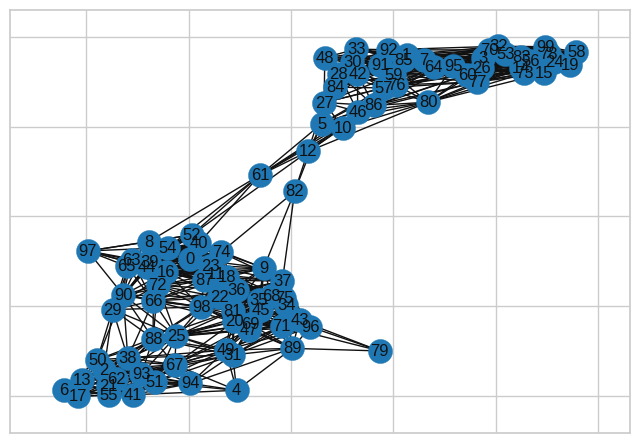

In [24]:
nx.draw_networkx(graph_red)

In [25]:
nx.write_graphml(graph_red, path+"network_red.graphml")

In [26]:
df_sample.iloc[81]

,646
age,37
job,technician
marital,married
education,secondary
default,no
balance,123
housing,yes
loan,yes
